# TEAM-KMJS (a.k.a Team Sasa)     
### Sprint4 - News 

In [1]:
import spacy
import en_core_web_lg

import gensim 
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

import pyLDAvis.gensim

import numpy as np 
import pandas as pd
import math 

import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob 
# https://www.loc.gov/standards/iso639-2/php/code_list.php

from collections import  Counter
import string, os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Optiplex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Optiplex\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Optiplex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(f'SpaCy:\t{spacy.__version__}')
print(f'en_core_web_lg:\t{en_core_web_lg.__version__}')
print(f'NLTK:\t{nltk.__version__}')
print(f'gensim:\t{gensim.__version__}')

SpaCy:	3.0.3
en_core_web_lg:	3.0.0
NLTK:	3.5
gensim:	3.8.3


In [3]:

### NLP Model
# NLP = en_core_web_lg.load()
NLP = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


### Stop Words
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['news', 'advertisement', 'rappler', 'gma', 'inquirer', 'manila', 'philippines', 'philippine', 'bulletin', 'star',\
    'cnn', 'abs', 'cbn', 'abscbn', 'abs-cbn', 'sunstar', 'covid', 'covid-19', 'covid19', 'vaccine', 'say'])
TAGALOG = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ii
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

STOPWORDS.extend(TAGALOG)
print(STOPWORDS)

### Doc Object
def get_doc(text):
    docstring =  str(''.join([i if ord(i) < 128 else ' ' for i in text]))
    return NLP(docstring)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
FILENAME = 'datasets/combined_and_cleaned.csv'

df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])
df['authors'].fillna('sunstar', inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              898 non-null    object
 1   titles            898 non-null    object
 2   authors           898 non-null    object
 3   published_dates   898 non-null    object
 4   articles_content  898 non-null    object
 5   news_org          898 non-null    object
dtypes: object(6)
memory usage: 42.2+ KB


,urls,titles,authors,published_dates,articles_content,news_org
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler
...,...,...,...,...,...,...
893,https://newsinfo.inquirer.net/1401139/coronava...,CoronaVac rollout begins; AstraZeneca delayed,Maricar Cinco,2021-03-01 05:00:00,FINALLY The Philippines’ vaccination drive sta...,Inquirer
894,https://globalnation.inquirer.net/194085/ph-re...,PH reserves 6 M doses of Johnson & Johnson’s C...,Christia Marie Ramos,2021-03-01 08:27:00,A vial and sryinge are seen in front of a disp...,Inquirer
895,https://globalnation.inquirer.net/190193/duter...,Duterte says Russia may give COVID-19 vaccine ...,Krissy Aguilar,2020-08-11 15:52:00,"MANILA, Philippines — Russia is willing to pro...",Inquirer
896,https://globalnation.inquirer.net/192800/top-u...,Top US official will try to get back fraction ...,Katrina Hallare,2020-12-19 11:48:00,FILE PHOTO: A woman holds a small bottle label...,Inquirer


# TOPIC MODELING
### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Tokenize words and Clean-up text


In [5]:
# Convert to list
data = df['articles_content'].values.tolist()

# Convert R&D to Research and Development
data = [sent.lower().replace('r&d', 'Research and Development') for sent in data]

# Remove URLs
data = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", '', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# # Remove underscore characters
# data = [re.sub('(_)', ' ', sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list(sent_to_words(data))

print(data[:1])

[['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid', 'february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task', 'force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar', 'carlito', 'galvez', 'jr', 'and', 'national', 'task', 'force', 'covid', 'deputy', 'chief', 'implementer', 'vince', 'dizon', 'pointed', 'to', 'documentary', 'requirements', 'involving', 'an', 'indemnification', 'fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification

## Creating Bigram and Trigram Models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid_february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task_force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar_carlito_galvez_jr', 'and', 'national_task_force', 'covid', 'deputy_chief_implementer_vince', 'dizon', 'pointed', 'to', 'documentary_requirements', 'involving', 'an', 'indemnification_fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification_fund', 'an', 'indemnification_fund',

## Remove Stopwords, Make Bigrams and Lemmatize


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = NLP(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [8]:
# Do lemmatization keeping only noun, adj, vb, adv
data = lemmatization(data)

# Remove Stop Words
data = remove_stopwords(data)
# data = remove_stopwords(data)
# data = remove_stopwords(data)

# Form Bigrams | Trigrams
data = make_bigrams(data)

#### NOTE: lemmatization was move to first pass
# # Do lemmatization keeping only noun, adj, vb, adv
# data = lemmatization(data)

print(data[:1])

[['government', 'need', 'key', 'measure', 'indemnification_fund', 'sign', 'law', 'pandemic', 'official', 'announce', 'delivery', 'country', 'first', 'batch', 'coronavirus', 'expect', 'mid_february', 'timeline', 'look', 'less', 'likely', 'meet', 'duterte', 'government', 'task_force', 'official', 'announce', 'slight', 'delay', 'arrival', 'thing', 'paperwork', 'czar', 'galvez_jr', 'national', 'task_force', 'deputy_chief', 'implementer_vince', 'dizon', 'point', 'documentary', 'requirement', 'involve', 'indemnification_fund', 'culprit', 'delay', 'schedule', 'need', 'indemnification_fund', 'indemnification_fund', 'galvez', 'early', 'tell', 'lawmaker', 'congressional', 'hearing', 'necessary', 'gain', 'access', 'dose', 'pharmaceutical', 'company', 'well', 'global', 'facility', 'request', 'lawmaker', 'consider', 'bill', 'provide', 'mid', 'january', 'add', 'give', 'opportunity', 'gain', 'access', 'large', 'supply', 'increase', 'public', 'confidence', 'government', 'rollout', 'reason', 'indemnifi

### Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word_dictionary = Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word_dictionary.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
# [(id2word_dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 2), (1, 1), (2, 5), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 8), (10, 1), (11, 7), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 5), (18, 1), (19, 1), (20, 2), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 3), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 12), (41, 1), (42, 5), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 4), (49, 2), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 2), (56, 4), (57, 1), (58, 1), (59, 1), (60, 1), (61, 9), (62, 1), (63, 2), (64, 3), (65, 1), (66, 1), (67, 1), (68, 1), (69, 6), (70, 3), (71, 1), (72, 3), (73, 1), (74, 2), (75, 1), (76, 1), (77, 3), (78, 1), (79, 2), (80, 3), (81, 2), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 2), (88, 3), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 2), (103, 1), (104, 2), (105, 2), (106, 3), (107, 4), (108, 1), (109, 1), (110, 1

## Building the Topic Model

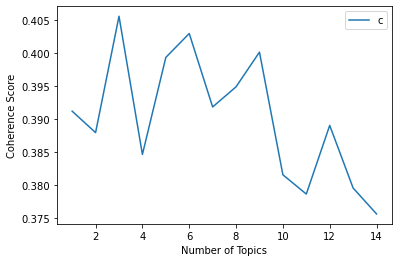

Model[0] ~> N-Topics ~>  1 has Coherence Value of ~> 0.3912
Model[1] ~> N-Topics ~>  2 has Coherence Value of ~> 0.388
Model[2] ~> N-Topics ~>  3 has Coherence Value of ~> 0.4056
Model[3] ~> N-Topics ~>  4 has Coherence Value of ~> 0.3847
Model[4] ~> N-Topics ~>  5 has Coherence Value of ~> 0.3994
Model[5] ~> N-Topics ~>  6 has Coherence Value of ~> 0.403
Model[6] ~> N-Topics ~>  7 has Coherence Value of ~> 0.3919
Model[7] ~> N-Topics ~>  8 has Coherence Value of ~> 0.3949
Model[8] ~> N-Topics ~>  9 has Coherence Value of ~> 0.4002
Model[9] ~> N-Topics ~> 10 has Coherence Value of ~> 0.3816
Model[10] ~> N-Topics ~> 11 has Coherence Value of ~> 0.3787
Model[11] ~> N-Topics ~> 12 has Coherence Value of ~> 0.3891
Model[12] ~> N-Topics ~> 13 has Coherence Value of ~> 0.3796
Model[13] ~> N-Topics ~> 14 has Coherence Value of ~> 0.3757
Wall time: 26min 13s


In [10]:
%%time 

limit = 15; start = 1; step = 1
coherences = []
models = []

for N in range(start, limit, step):
    ldamodel = LdaModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary,random_state=42)
    models.append(ldamodel)

    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    coherences.append((ldacoherence))


# Plot the number of topics based on coherence score
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend('coherences', loc='best')
plt.show()  


# Print the coherence scores
idx = 0
for n, cv in zip(x, coherences):
    print(f'Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

In [11]:
# INTENTIONAL EXCEPTION
raise Exception('Select the BEST MODEL')

Exception: Select the BEST MODEL

In [ ]:
%%time 

limit = 15; start = 1; step = 1
coherences = []
models2 = []

for N in range(start, limit, step):
    lsimodel = LsiModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary,random_state=42)
    models2.append(lsimodel)

    lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
    lsicoherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    coherences.append((lsicoherence))


# Plot the number of topics based on coherence score
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend('coherences', loc='best')
plt.show()  


# Print the coherence scores
idx = 0
for n, cv in zip(x, coherences):
    print(f'Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

In [15]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=id2word_dictionary)
hdpmodel = HdpModel(corpus=corpus, id2word=id2word_dictionary)
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=id2word_dictionary)

In [16]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [17]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10],texts=texts,dictionary=id2word_dictionary,window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10],texts=texts,dictionary=id2word_dictionary,window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics[:10],texts=texts,dictionary=id2word_dictionary,window_size=10).get_coherence()

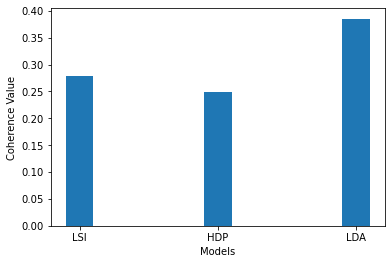

In [18]:
# Then we compare a bar chart to compare the three models
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2,tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    

# LSI wins
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP', 'LDA'])

In [23]:
# Select the BEST model and print the topics
best_model = models[4]
topics = best_model.show_topics(formatted=False)

In [ ]:
# # ## SHORTCUT TO BESTMODEL rather than running 51 loop
# best_model = LdaModel(corpus=corpus, num_topics=6, id2word=id2word_dictionary,random_state=24)
# topics = best_model.show_topics(formatted=False)

In [ ]:

# from collections import Counter
# import matplotlib.colors as mcolors


# data_flat = [w for w_list in data for w in w_list]
# counter = Counter(data_flat)

# out = []
# for i, topic in topics:
#     for word, weight in topic:
#         out.append([word, i , weight, counter[word]])

# dff = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# # Plot Word Count and Weights of Topic Keywords
# fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
# for i, ax in enumerate(axes.flatten()):
#     ax.bar(x='word', height="word_count", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
#     ax_twin = ax.twinx()
#     ax_twin.bar(x='word', height="importance", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
#     ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
#     ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
#     ax.tick_params(axis='y', left=False)
#     ax.set_xticklabels(dff.loc[dff.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
#     ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# fig.tight_layout(w_pad=2)    
# fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
# plt.show()
# dff

In [24]:
best_model = models[4]
topics = best_model.show_topics(formatted=False)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus, id2word_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.007886 -0.003601       1        1  34.331998
2     -0.006865  0.008768       2        1  23.664380
1     -0.004822 -0.004300       3        1  23.566247
4      0.008531 -0.008220       4        1   9.756292
3      0.011042  0.007353       5        1   8.681083, topic_info=            Term         Freq        Total Category  logprob  loglift
146   government  1760.000000  1760.000000  Default  30.0000  30.0000
135        first  1427.000000  1427.000000  Default  29.0000  29.0000
104         dose  2174.000000  2174.000000  Default  28.0000  28.0000
151       health  2250.000000  2250.000000  Default  27.0000  27.0000
344  vaccination  1598.000000  1598.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
272      receive    67.457022  1027.688633   Topic5  -5.5596  -0.2796
704       people    57.840123   782.243093   Topic5  -5.7134  -0.1605
206        march    54.581286   699.433024   Topic5  -5.7714  -0.1066
499      sinovac    67.359397  1407.809978   Topic5  -5.5610  -0.5957
419     hospital    56.436871  1075.422689   Topic5  -5.7379  -0.5033

[440 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         1  0.318593  accord
3         2  0.272642  accord
3         3  0.186867  accord
3         4  0.128662  accord
3         5  0.094965  accord
...     ...       ...     ...
353       5  0.064035    year
7690      1  0.756722  ylagan
7690      2  0.189180  ylagan
7690      3  0.189180  ylagan
8719      3  0.562404  zabala

[980 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

In [29]:
best_model = models[5]
topics = best_model.show_topics(formatted=False)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus, id2word_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.008651 -0.007196       1        1  33.562012
2      0.008991  0.009645       2        1  22.053934
1      0.005633 -0.005374       3        1  21.752637
4     -0.009500 -0.007700       4        1   8.587562
3     -0.011879  0.004729       5        1   8.153012
5     -0.001896  0.005896       6        1   5.890843, topic_info=           Term         Freq        Total Category  logprob  loglift
104        dose  2123.000000  2123.000000  Default  30.0000  30.0000
146  government  1775.000000  1775.000000  Default  29.0000  29.0000
135       first  1433.000000  1433.000000  Default  28.0000  28.0000
151      health  2279.000000  2279.000000  Default  27.0000  27.0000
526      worker  1374.000000  1374.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
69      country    49.673663  1548.385311   Topic6  -5.4778  -0.6077
106       early    35.744560   693.194281   Topic6  -5.8069  -0.1331
81          day    33.288265   579.398525   Topic6  -5.8781  -0.0250
419    hospital    40.689157  1092.277259   Topic6  -5.6774  -0.4583
704      people    34.154242   792.006377   Topic6  -5.8524  -0.3119

[521 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         1  0.310412     accord
3         2  0.255091     accord
3         3  0.165963     accord
3         4  0.113715     accord
3         5  0.089128     accord
...     ...       ...        ...
1822      6  0.071507  zamboanga
4573      3  0.232894       zink
4573      4  0.232894       zink
4573      5  0.232894       zink
4573      6  0.232894       zink

[1262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4, 6])

## Finding the dominant topic in each sentence

In [30]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_weighted_keywords = dict()
                for word, prop in wp:
                    topic_weighted_keywords[word] = prop
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords,topic_weighted_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_contribution', 'topic_keywords',"topic_weighted_keywords"]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_id','dominant_topic', 'topic_percentage_contribution', 'keywords',"weighted_keywords", 'text']
df_dominant_topic = df_dominant_topic.drop('document_id', axis=1)

# Show
# print(f'{df_dominant_topic.shape[0]} == {df.shape[0]}')
df_dominant_topic

,dominant_topic,topic_percentage_contribution,keywords,weighted_keywords,text
0,1.0,0.5263,"health, dose, vaccination, city, country, gove...","{'health': 0.01112786, 'dose': 0.009510259, 'v...","[government, need, key, measure, indemnificati..."
1,0.0,0.4669,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...","[update, march, finally, begin, legally, roll,..."
2,2.0,0.9874,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[update, malacanang, dose, global, facility, h..."
3,0.0,0.9033,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...","[update, low, efficacy, trial, brazil, lead, e..."
4,0.0,0.9842,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...","[rd, update, arrival, donate, china, pave, way..."
...,...,...,...,...,...
893,2.0,0.8513,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[finally, vaccination, drive, start, monday, d..."
894,2.0,0.5312,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[vial, sryinge, see, front, display, johnson_j..."
895,2.0,0.9967,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[russia, willing, provide, free, president, vo..."
896,3.0,0.7260,"health, dose, vaccination, worker, first, get,...","{'health': 0.0101174265, 'dose': 0.007968538, ...","[file_photo, woman, hold, small_bottle, label,..."


## Find the most representative document for each topic

In [33]:
# Group top N sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['percentage_contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['topic_id', "topic_percentage_contribution", "keywords","weighted_keywords", "text"]

# ### Save the dataset as CSV
# sent_topics_sorteddf.to_csv('datasets/topics.csv')

##save to csv when changed keywords to frequencies
##sent_topics_sorteddf.to_csv("datasets/wordcloud_topics.csv")
# Show
print(sent_topics_sorteddf.shape)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf

(6, 5)


,topic_id,topic_percentage_contribution,keywords,weighted_keywords,text
0,0.0,0.9988,"health, country, government, dose, vaccination, sinovac, city, worker, get, also","{'health': 0.012201888, 'country': 0.010601774, 'government': 0.009654868, 'dose': 0.009248641, 'vaccination': 0.008126006, 'sinovac': 0.007666578, 'city': 0.0076484396, 'worker': 0.0071665025, 'get': 0.006978642, 'also': 0.005316361}","[instant, nursing, director, chelsey, earnest, recall, bad, day, work, ever, sometimes, come, back, try, remember, happen, march, dawn, night, haunt, siren, seem, blare, endlessly, life, care, center, kirkland, washington, night, ambulance, parking, lot, night, send, patient, hospital, expect, treat, eventually, release, never, come, back, date, figure, whole, cascade, symptom, virus, nursing_home, learn, invade, day, early, also, day, make, gut, wrench, phone, call, shake, mind, remember, conversation, woman, end, line, realize, early, morning, difficult, really, sorry, mom, pass, away, earnest, cry, never, meet, share, heartbreaking, moment, month, later, still, sometimes, talk, earnest, earnest, registered, nurse, volunteer, help, kirkland, nursing_home, position, nursing, ...]"
1,1.0,0.9986,"health, dose, vaccination, city, country, government, hospital, sinovac, also, get","{'health': 0.01112786, 'dose': 0.009510259, 'vaccination': 0.0092989, 'city': 0.008640214, 'country': 0.008035347, 'government': 0.007715937, 'hospital': 0.0069171707, 'sinovac': 0.0068376637, 'also': 0.006621545, 'get': 0.0062120613}","[new, delhi, never, go, away, expert, likely, version, disease, linger, year, look, future, less, clear, coronavirus, already, kill, people, worldwide, eventually, eliminate, global, vaccination, campaign, smallpox, dangerous, new, variant, evade, virus, stick, around, long, time, transform, mild, annoyance, common_cold, eventually, virus, know, sar, cov, become, yet, animal, zoo, join, many, infectious_disease, humanity, learn, live, predict, study, virus, helm, india, effort, tackle, polio, hiv, aid, file, file_photo, people, stand, sign, wait, line, receive, first, dose, pfizer, day, vaccination, clinic, set, amazon, com, facility, seattle, operate, virginia, mason, franciscan, health, scientist, still, early, predict, future, coronavirus, many, doubt, ever, go, away, entirely, ...]"
2,2.0,0.9972,"dose, health, first, hospital, sinovac, worker, government, vaccination, receive, get","{'dose': 0.013471795, 'health': 0.011792475, 'first': 0.011324531, 'hospital': 0.008791758, 'sinovac': 0.008538561, 'worker': 0.007957714, 'government': 0.007651702, 'vaccination': 0.0075302077, 'receive': 0.007143162, 'get': 0.006795298}","[first, batch, nurse, medical, worker, rodriguez_memorial, caloocan, city, receive, sinovac, marianne, monday, kick, vaccination, drive, use, dose, donate, chinese, coronavac, major, government, hospital, metro, number, healthcare, government, official, worker, government, official, vaccinate, jab, general, hospital, pgh, medical, worker, government, official, also, vaccinate, rodriguez_memorial, hospital, sanitarium_tala, hospital, caloocan, city, government, run, hospital, following, receive, first, dose, thecoronavac, general, hospital, pgh, pgh, director, dr_gerardo, gap, infectious_disease, specialist, dr_edsel, salvana, food, drug_administration, director, metro, development_authority, chairman, benjamin, ntf, medical, adviser, czar, galvez_jr, nurse, marian, villanueva, dr, jose_rodriguez, memorial, medical_center, sanitarium_tala, tala, hospital, medical_center, chief, dr, alfonso, victorino, famaran, jr, test, czar, ntf, deputy_chief, ...]"
3,3.0,0.9982,"health, dose, vaccination, worker, first, get, government, astrazeneca, country, vaccinate","{'health': 0.0101174265, 'dose': 0.007968538, 'vaccination': 0.007508553, 'worker': 0.006592226, 'first': 0.0065525505, 'get': 0.0063500884, 'government': 0.006097255, 'astrazeneca': 0.005738251, 'country': 0.005522184, 'vaccinate': 0.0051844595}","[win

## Topic distribution across documents

In [34]:
pd.reset_option('^display', silent=True)

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['dominant_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['dominant_topic', 'topic_keywords',"topic_weighted_keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['dominant_topic', 'topic_keywords',"weighted_keywords", 'num_documents', 'percentage_documents']

# Show
# df_dominant_topics = df_dominant_topics[~df_dominant_topics['num_documents'].isna()][['topic_keywords']]
df_dominant_topics

,dominant_topic,topic_keywords,weighted_keywords,num_documents,percentage_documents
0.0,1.0,"health, dose, vaccination, city, country, gove...","{'health': 0.01112786, 'dose': 0.009510259, 'v...",308.0,0.3430
1.0,0.0,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...",184.0,0.2049
2.0,2.0,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...",211.0,0.2350
3.0,0.0,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...",61.0,0.0679
4.0,0.0,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...",82.0,0.0913
...,...,...,...,...,...
893.0,2.0,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...",NaN,NaN
894.0,2.0,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...",NaN,NaN
895.0,2.0,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...",NaN,NaN
896.0,3.0,"health, dose, vaccination, worker, first, get,...","{'health': 0.0101174265, 'dose': 0.007968538, ...",NaN,NaN


# FINAL DF

In [35]:
sia = SentimentIntensityAnalyzer()

def get_vader_polarity(text):
    return sia.polarity_scores(text)['compound']

def get_vader_negativity(text):
    return sia.polarity_scores(text)['neg']

def get_vader_neutrality(text):
    return sia.polarity_scores(text)['neu']

def get_vader_positivity(text):
    return sia.polarity_scores(text)['pos']

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_analysis(score):
    if score <= -0.05:
        return 'Negative'
    elif score >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [37]:
df = pd.concat([df, df_dominant_topic.reindex(df.index)], axis=1)
df

,urls,titles,authors,published_dates,articles_content,news_org,dominant_topic,topic_percentage_contribution,keywords,weighted_keywords,text
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler,1.0,0.5263,"health, dose, vaccination, city, country, gove...","{'health': 0.01112786, 'dose': 0.009510259, 'v...","[government, need, key, measure, indemnificati..."
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler,0.0,0.4669,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...","[update, march, finally, begin, legally, roll,..."
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler,2.0,0.9874,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[update, malacanang, dose, global, facility, h..."
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler,0.0,0.9033,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...","[update, low, efficacy, trial, brazil, lead, e..."
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler,0.0,0.9842,"health, country, government, dose, vaccination...","{'health': 0.012201888, 'country': 0.010601774...","[rd, update, arrival, donate, china, pave, way..."
...,...,...,...,...,...,...,...,...,...,...,...
893,https://newsinfo.inquirer.net/1401139/coronava...,CoronaVac rollout begins; AstraZeneca delayed,Maricar Cinco,2021-03-01 05:00:00,FINALLY The Philippines’ vaccination drive sta...,Inquirer,2.0,0.8513,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[finally, vaccination, drive, start, monday, d..."
894,https://globalnation.inquirer.net/194085/ph-re...,PH reserves 6 M doses of Johnson & Johnson’s C...,Christia Marie Ramos,2021-03-01 08:27:00,A vial and sryinge are seen in front of a disp...,Inquirer,2.0,0.5312,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[vial, sryinge, see, front, display, johnson_j..."
895,https://globalnation.inquirer.net/190193/duter...,Duterte says Russia may give COVID-19 vaccine ...,Krissy Aguilar,2020-08-11 15:52:00,"MANILA, Philippines — Russia is willing to pro...",Inquirer,2.0,0.9967,"dose, health, first, hospital, sinovac, worker...","{'dose': 0.013471795, 'health': 0.011792475, '...","[russia, willing, provide, free, president, vo..."
896,https://globalnation.inquirer.net/192800/top-u...,Top US official will try to get back fraction ...,Katrina Hallare,2020-12-19 11:48:00,FILE PHOTO: A woman holds a small bottle label...,Inquirer,3.0,0.7260,"health, dose, vaccination, worker, first, get,...","{'health': 0.0101174265, 'dose': 0.007968538, ...","[file_photo, woman, hold, small_bottle, label,..."


In [41]:
# Data Analysis
df['polarity'] = df['text'].str.join(' ').apply(get_vader_polarity)
df['negativity'] = df['text'].str.join(' ').apply(get_vader_negativity)
df['neutrality'] = df['text'].str.join(' ').apply(get_vader_neutrality)
df['positivity'] = df['text'].str.join(' ').apply(get_vader_positivity)
df['subjectivity'] = df['text'].str.join(' ').apply(get_subjectivity)
df['analysis'] = df['polarity'].apply(get_analysis)

# Save the model dataset as CSV
FILENAME = 'datasets/wordcloud_model2.csv'
df.to_csv(FILENAME, index=False)


In [ ]:
### Read the MODEL dataset
df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])
df.info()
df

In [ ]:
import plotly.express as px

fig = px.scatter(df,
                x='polarity',
                y='subjectivity',
                color='analysis',
                size='subjectivity'
                )

fig.update_layout(title='Sentiment Analysis',
                shapes=[dict(
                    type='line',
                    yref='paper', y0=0, y1=1,
                    xref='x', x0=0, x1=0
                )]
                )

fig.show()

In [ ]:
# def to_english(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='en'))
#     except:
#         pass
#     return result

# def to_tagalog(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='tl'))
#     except:
#         pass
#     return result
